In [2]:
from sage.all import *
from sage.all import Matrix

In [3]:
""" Returns the volume of G """

def vol(G):
    V = 0
    for v in G.vertices():
        V+=G.degree(v)
    return V

In [4]:
""" Returns the degree matrix D of graph G"""

def deg_matrix(G):
    return diagonal_matrix([G.degree(v) for v in G.vertices()], sparse = False)

In [5]:
""" Returns Ihara Matrix of G """

def ihara_matrix(G):
    A = G.adjacency_matrix(); D=deg_matrix(G); I = identity_matrix(G.order()); Z=matrix.zero(G.order())
    return block_matrix(QQbar, [[A,D-I],[-I,Z]], subdivide = False)

In [6]:
""" Returns the normal transition probabillity matrix P of graph G """

def trans_prob_matrix(G):
    A = G.adjacency_matrix()
    D= diagonal_matrix([G.degree(v) for v in G.vertices()])
    Dinv = D^(-1)
    P = Dinv * A
    return P

In [7]:
def edge_ordering_dictionary(G):
    D=dict()
    i=0
    for u in G.vertices():
        for v in G.neighbors(u):
            D.setdefault((u,v),i)
            i=i+1
    return D

In [8]:
""" Creates probability matrix of the non-backtracking matrix """

def trans_prob_matrix_nb(G):
    L = []
    D=edge_ordering_dictionary(G)
    for a in D.keys():
        i=D[a]
        for b in D.keys():
            j=D[b]
            u=a[0]
            v=a[1]
            x=b[0]
            y=b[1]
            if v==x and y!=u:
                L.append(float(1)/(G.degree(v)-1))
            else: L.append(0)
    P = matrix(vol(G), L)
    return P

In [9]:
""" Creates normal edge adjacency matrix C for any graph G """

def edge_adjacency_matrix(G):
    L = []
    D=edge_ordering_dictionary(G)
    for a in D.keys():
        i=D[a]
        for b in D.keys():
            j=D[b]
            u=a[0]
            v=a[1]
            x=b[0]
            y=b[1]
            if v==x:
                L.append(1)
            else: L.append(0)
    B = matrix(vol(G), L)
    return B

In [10]:
""" Creates non-backtracking matrix B for any graph G """

def edge_adjacency_nb_matrix(G):
    L = []
    D=edge_ordering_dictionary(G)
    for a in D.keys():
        i=D[a]
        for b in D.keys():
            j=D[b]
            u=a[0]
            v=a[1]
            x=b[0]
            y=b[1]
            if v==x and y!=u:
                L.append(1)
            else: L.append(0)
    B = matrix(vol(G), L) 
    return B

In [11]:
""" Uses proposition 5.3 to calculate eigenvalues of Ihara Matrix from A """
def compute_K_evals(G):
    K = ihara_matrix(G)
    for A_evec in G.eigenvectors():
        print("lambda: " + str(A_evec[0]))
        for K_evec in K.eigenvectors_right():
            mu = K_evec[0]
            print("Actual mu: " + str(mu))
            G1 = A_evec
            lam = G1[0]
            x_vectors = G1[1]
            for A_evec_same_eval in x_vectors:
                x = list(A_evec_same_eval)
                x = vector(x)
                B_evec = K_evec[1]
                for K_evec_same_eval in B_evec:
                    evec_list = list(K_evec_same_eval)
                    evec_half = evec_list[G.order():]
                    y = vector(evec_half)
                    D = deg_matrix(G)
                    if x*y != 0:
                        mu1_calculated = (lam + sqrt(lam^2 - 4/(x*y)*x*(D - identity_matrix(len(y)))*y)) / 2
                        mu2_calculated = (lam - sqrt(lam^2 - 4/(x*y)*x*(D - identity_matrix(len(y)))*y)) / 2
                        if mu == mu1_calculated or mu == mu2_calculated:
                            print("CORRECT")
                        else:
                            print("INCORRECT")
                    else: 
                        print("x and y are orthogonal")
        print()

In [12]:
""" Tries to find all eigenvalues of Ihara Matrix using Proposition 5.3. If not all are found, 
it prints off the graph of G and a list of eigenvalues that weren't calculated. """

#Takes a long time

def find_eigenvalues(G):    
    K = ihara_matrix(G)
    set_of_evals = list(K.eigenvalues())
    for A_evec in G.eigenvectors():
        for K_evec in K.eigenvectors_right():
            mu = K_evec[0]
            lam = A_evec[0]
            x_vectors = A_evec[1]
            for A_evec_same_eval in x_vectors:
                x = list(A_evec_same_eval)
                x = vector(x)
                K_evectors = K_evec[1]
                for K_evec_same_eval in K_evectors:
                    evec_list = list(K_evec_same_eval)
                    evec_half = evec_list[G.order():]
                    y = vector(evec_half)
                    D = deg_matrix(G)
                    if x*y != 0:
                        mu1_calculated = (lam + sqrt(lam^2 - 4/(x*y)*x*(D - identity_matrix(len(y)))*y)) / 2
                        mu2_calculated = (lam - sqrt(lam^2 - 4/(x*y)*x*(D - identity_matrix(len(y)))*y)) / 2
                        if mu == mu1_calculated or mu == mu2_calculated:
                            if mu in set_of_evals:
                                set_of_evals.remove(mu)
    if len(set_of_evals) == 0:
        print("All eigenvalues found")
    else:
        print("These eigenvalues were not found: " + str(set_of_evals))
        show(G)

In [13]:
""" Returns list of eigenvectors corresponding to jth eigenvalue """

def get_ihara_evec(G,j):
    K = ihara_matrix(G)
    K_i = K.eigenvectors_right()[j]
    K_i_evec = K_i[1]
    return K_i_evec

In [14]:
""" Tells you if the Ihara matrix is diagonalizable """

def is_it_diagonalizable(list_of_graphs):
    for g in list_of_graphs:
        k = ihara_matrix(g)
        if k.is_diagonalizable() == False:
            show(g)

In [15]:
""" Checks if two graphs are adjacency cospectral """
def adjancency_cospectral(g1,g2):
    return g1.spectrum() == g2.spectrum()

In [16]:
""" Checks if two graphs are laplacian cospectral """
def laplacian_cospectral(g1,g2):
    return g1.kirchhoff_matrix().eigenvalues() == g2.kirchhoff_matrix().eigenvalues()

In [17]:
""" Checks if two graphs are signless cospectral """
def signless_cospectral(g1,g2):
    return g1.kirchhoff_matrix(signless=True).eigenvalues() == g2.kirchhoff_matrix(signless=True).eigenvalues()

In [18]:
""" Checks if two graphs are normalized laplacian cospectral """
def normalized_cospectral(g1,g2):
    # TAKES TOO LONG TO RUN THIS 
    return g1.kirchhoff_matrix(normalized=True).eigenvalues() == g2.kirchhoff_matrix(normalized=True).eigenvalues()

In [19]:
""" Checks if two graphs are ihara cospectral """
def ihara_cospectral(g1,g2):
    return ihara_matrix(g1).eigenvalues() == ihara_matrix(g2).eigenvalues()

In [20]:
""" Checks if two graphs are nonbacktracking cospectral """
def nonbactracking_cospectral(g1,g2):
    return edge_adjacency_nb_matrix(g1).eigenvalues() == edge_adjacency_nb_matrix(g2).eigenvalues()

In [21]:
""" Shows cospectrality in regards to relevant matrices and Ihara matrix """

def show_cospectrality(g1,g2):
    print("Cospectrality")
    print("\tAdjacency: " + str(adjancency_cospectral(g1,g2)))
    print("\tLaplacian: " + str(laplacian_cospectral(g1,g2)))
    print("\tSignless: " + str(signless_cospectral(g1,g2)))
    print("\tIhara: " + str(ihara_cospectral(g1,g2)))
    print("\tNonbacktracking: " + str(nonbactracking_cospectral(g1,g2)))
    



In [22]:
def GM_switch(g1,g2,C):
    if g1.is_regular() != True:
        print("Graph 1 is not regular")
        return
    else:
        J = ones_matrix(g1.order(), g2.order())
        AG = block_matrix(QQbar, [[g1.adjacency_matrix(),C],[C.transpose(),g2.adjacency_matrix()]], subdivide = False)
        AH = block_matrix(QQbar, [[g1.adjacency_matrix(),J - C],[J.transpose() - C.transpose(),g2.adjacency_matrix()]], subdivide = False)
        G = Graph(AG)
        H = Graph(AH)
        return G,H

In [23]:
@parallel(p_iter='reference', ncpus = 32)
def graph_list(gen):
    graph_list = []  # Use the correct variable name
    for graph in gen:  # Iterate over the generator directly
        # if type(graph) is Graph:
        graph_list.append(graph)
    return graph_list

In [24]:
@parallel(p_iter='reference', ncpus = 32)
def parallel_nb_cospectral_finder(gen):  # Now accepts an iterator
    spec_set = set()
    spec_dict = {}

    for G in gen:  # Iterate directly over the input
        if type(G) is Graph:
            spectrum = str(edge_adjacency_nb_matrix(G).eigenvalues())
            if spectrum in spec_dict:
                spec_set.add(spectrum)
                spec_dict[spectrum].append(G)
            else:
                spec_dict.update({spectrum: [G]})

    print("About to return")
    return spec_set, spec_dict  # Return results

In [25]:

def parallel_function(gen):
    spec_set = set()
    spec_dict = {}

    G = next(gen)
    while True:
        try:
            G = next(gen)
            spectrum = str(edge_adjacency_nb_matrix(G).eigenvalues())
            if spectrum in spec_dict:
                spec_set.add(spectrum)
                spec_dict[spectrum].append(G)
            else:
                spec_dict.update({spectrum: [G]})
            
        except StopIteration:
            break

    for cospectrum in spec_set:
        for G in spec_dict[cospectrum]:
            G.show()

In [26]:
def GM_switch(g1,g2,C):
    if g1.is_regular() != True:
        print("Graph 1 is not regular")
        return
    else:
        J = ones_matrix(g1.order(), g2.order())
        AG = block_matrix(QQbar, [[g1.adjacency_matrix(),C],[C.transpose(),g2.adjacency_matrix()]], subdivide = False)
        AH = block_matrix(QQbar, [[g1.adjacency_matrix(),J - C],[J.transpose() - C.transpose(),g2.adjacency_matrix()]], subdivide = False)
        G = Graph(AG)
        H = Graph(AH)
        return G,H

In [27]:
def parse_sage_graphs(graph_strings):
    graph_objects = tuple(Graph(eval(graph_dict)) for graph_dict in graph_strings)
    return graph_objects

In [28]:
def all_pairs_ihara_cospectral(graphs):
    n = len(graphs)
    for i in range(n):
        for j in range(i + 1, n):
            if not ihara_cospectral(graphs[i], graphs[j]):
                print('Following graphs are NOT ihara cospectral')
                print(graphs[i].to_dictionary())
                print(graphs[j].to_dictionary())
            else:
                print('Following graphs ARE ihara cospectral')
                print(graphs[i].to_dictionary())
                print(graphs[j].to_dictionary())
                

In [29]:
def all_pairs_same_ihara_function(graphs):
    n = len(graphs)
    for i in range(n):
        for j in range(i + 1, n):
            if graphs[i].ihara_zeta_function_inverse() != graphs[j].ihara_zeta_function_inverse():
                print('Following graphs DO NOT have same ihara function')
                print(graphs[i].to_dictionary())
                print(graphs[j].to_dictionary())
            else:
                print('Following graphs HAVE same ihara function')
                print(graphs[i].to_dictionary())
                print(graphs[j].to_dictionary())
                

In [30]:
def read_cospectral_pairs(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    i = 1
    while i <= len(lines) - 3:
        graph1_str = lines[i].strip()
        graph2_str = lines[i + 1].strip()
        i += 3
        yield (graph1_str, graph2_str)

In [31]:
import colorsys
def plot_eigenvalues_of_matrices(matrices : list):
    colors = rainbow(len(matrices))

    plot = sum(list_plot(matrices[i].eigenvalues(), size = 25, color = colors[i], markeredgecolor='black', legend_label=f"Matrix {i} Eigenvalues") for i in range(len(matrices)))
    plot.show(legend_loc='upper right')

In [32]:
def my_is_similar(A, B):
    A = A.matrix_over_field()
    B = B.matrix_over_field()
    ring = A.base_ring()
    print(ring)
    closure = ring.algebraic_closure()
    print(closure)
    A = A.change_ring(closure)
    B = B.change_ring(closure)
    _, SA = A.jordan_form(transformation=True)
    _, SB = B.jordan_form(transformation=True)
    return (SA * SB.inverse()).change_ring(QQ)

In [33]:
# Function to normalize each row by its norm squared
def square_normalize_rows(matrix):
    nrows, ncols = matrix.nrows(), matrix.ncols()
    
    for i in range(nrows):
        # Calculate the norm of the row (Euclidean norm)
        row_norm = sum(matrix[i, j]^2 for j in range(ncols))
        
        if row_norm != 0:  # Avoid division by zero
            for j in range(ncols):
                matrix[i, j] /= row_norm
    

In [34]:
def similarity_matrix_via_eigenmatrices(A, B):
    _, SRA = A.right_eigenmatrix()
    print('Obtained SRA')
    SRA = SRA[:, ::-1]
    _, SLB = B.left_eigenmatrix()
    print('Obtained SLB')
    SLB = SLB[::-1,:]
    square_normalize_rows(SLB)
    print('Normalized SLB')
    S = SRA*SLB
    print('Multiplied SRA and SLB')
    return S

In [35]:
from sage.matrix.special import block_matrix, ones_matrix
def laplacian_similarity_matrix_for_xo_graphs_alternating_labels(xo_array):
    n = len(xo_array) + 1
    # Initialize similarity 2d array
    O = Matrix(2)
    I = Matrix.identity(2)
    J = ones_matrix(2)
    A = J*(1/2)
    B = J*(-1/2) + I
    C = [Matrix(QQ, [[-1, 1],[1,-1]]), Matrix(QQ, [[1,-1],[-1,1]])]
    block_arr = [[O for i in range(n)] for j in range(n)]
    block_arr[0][0] = A
    block_arr[-1][-1] = A
    block_arr[0][-1] = B
    block_arr[-1][0] = B
    o_count = 0
    c_index = 0
    for i in range(1,n - 1):
        block_arr[i][i] = I
        if xo_array[i] == 1:
            o_count = 0
        else:
            for j in range(o_count + 1):
                block_arr[i + 1][i - j] = C[c_index]*(3**j)
                c_index = (c_index + 1) % 2
            c_index = 0
            o_count += 1
    return block_matrix(block_arr)

In [36]:
from xo_graphs import xo_dicts_gen
def xo_graphs_and_similarity_matrix_gen(n, similarity_matrix_constructor, isAlternating=True):
    xo_dict_pairs = xo_dicts_gen(n, isAlternating)
    for graph_dict_left, graph_dict_right, xo_array in xo_dict_pairs:
        if isAlternating:
            yield (graph_dict_left, graph_dict_right, similarity_matrix_constructor(xo_array))
        else:
            yield(graph_dict_left, graph_dict_right, None)

In [37]:
def display_non_similar_pairs_and_similarity_matrix(graphs_dict_pairs):
    for graph_dict_left, graph_dict_right, similarity_matrix in graphs_dict_pairs:
        graph_left = Graph(graph_dict_left)
        graph_right = Graph(graph_dict_right)
        laplacian_left : Matrix = (graph_left.kirchhoff_matrix())
        laplacian_right : Matrix = (graph_right.kirchhoff_matrix())
        if (laplacian_left*similarity_matrix != similarity_matrix*laplacian_right):
            print('XO PAIR AND SIMILARITY MATRIX DONT HOLD EQUALITY')
            
            graph_left.show(pos=obtain_positions_for_xo_graph(graph_dict_left, True))
            print('A = ')
            print(laplacian_left)

            graph_right.show(pos=obtain_positions_for_xo_graph(graph_dict_right, True))
            print('B = ')
            print(laplacian_right)

            print('\n Similarity Matrix=')
            print(similarity_matrix, '\n')

In [38]:
# This function uses the equitable partition labeling
from xo_graphs import obtain_positions_for_xo_graph
def display_all_pairs_of_xo_graphs_and_similarity_matrix(graphs_dict_pairs_and_similarity_matrix):
    for graph_dict_left, graph_dict_right, similarity_matrix in graphs_dict_pairs_and_similarity_matrix:
        print('XO PAIR AND SIMILARITY MATRIX')
        graph_left = Graph(graph_dict_left)
        graph_right = Graph(graph_dict_right)
        laplacian_left : Matrix = (graph_left.kirchhoff_matrix())
        laplacian_right : Matrix = (graph_right.kirchhoff_matrix())

        graph_left.show(pos=obtain_positions_for_xo_graph(graph_dict_left, True))
        print('A = ')
        print(laplacian_left)

        graph_right.show(pos=obtain_positions_for_xo_graph(graph_dict_right, True))
        print('B = ')
        print(laplacian_right)

        print('\n Similarity Matrix=')
        print(similarity_matrix, '\n')

        print('AS=')
        print(laplacian_left*similarity_matrix)

        print('SB=')
        print(similarity_matrix*laplacian_right)

XO PAIR AND SIMILARITY MATRIX


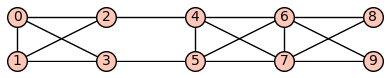

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0 -1 -1  0  2]


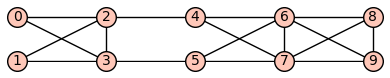

B = 
[ 2  0 -1 -1  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0]
[---------+---------+---------+---------+---------]
[   0    0|  -1    1|   1    0|   0    0|   0    0]
[   0    0|   1   -1|   0    1|   0    0|   0    0]
[---------+---------+---------+---------+---------]
[   0    0|   0    0|   0    0|   1    0|   0    0]
[   0    0|   0    0|   0    0|   0    1|   0    0]
[---------+---------+---------+---------+---------]
[ 1/2 -1/2|   0    0|   0    0

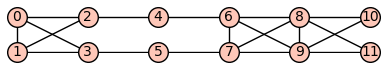

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  2]


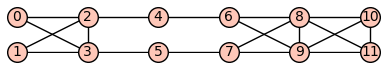

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0|   0    0]
[---------+---------+---------+---------+---------+---------]
[   0    0|  -1    1|   1    0|   0    0|   0    0|   0    0]
[   0    0|   1   -1|   0    1|   0    0|   0    0|   0    0]
[---------+---------+-

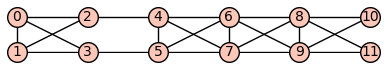

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  2]


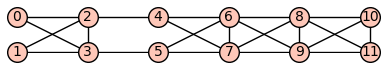

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0|   0    0]
[---------+---------+---------+---------+---------+---------]
[   0    0|  -1    1|   1    0|   0    0|   0    0|   0    0]
[   0    0|   1   -1|   0    1|   0    0|   0    0|   0    0]
[---------+---------+-

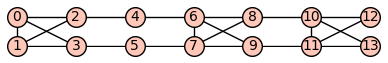

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


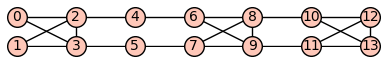

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0|   0    0|   0    0

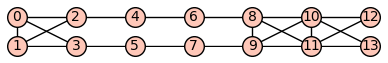

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


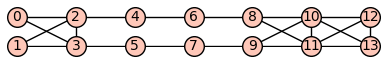

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0|   0    0|   0    0

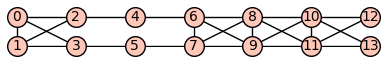

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


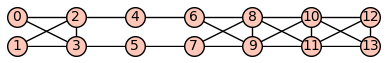

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0|   0    0|   0    0

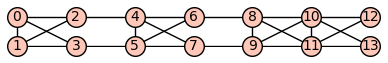

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


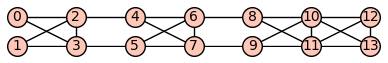

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0|   0    0|   0    0

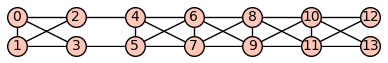

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


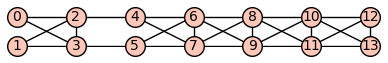

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0|   0    0|   0    0

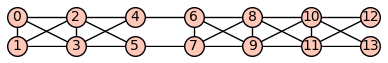

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


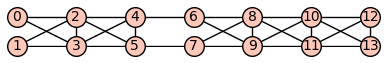

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------+---------+---------+---------+---------+---------+---------]
[   0    0|   1    0|   0    0|   0    0|   0    0|   0    0|   0    0]
[   0    0|   0    1|   0    0|   0    0|   0    0|   0    0|   0    0

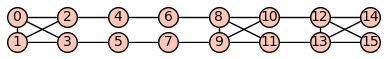

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


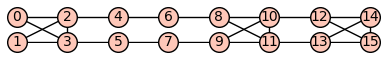

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

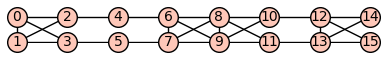

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


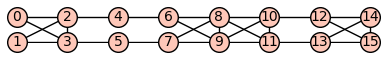

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

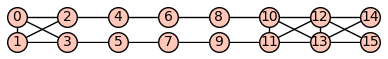

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


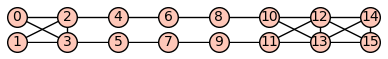

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

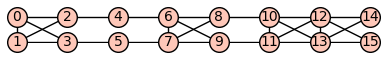

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


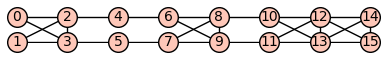

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

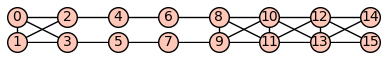

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


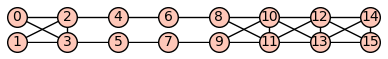

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

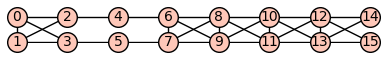

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


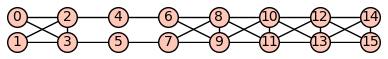

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

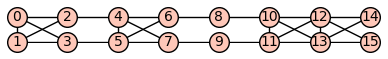

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


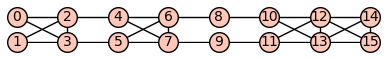

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

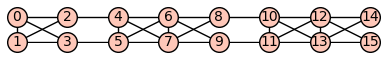

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


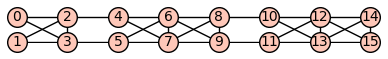

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

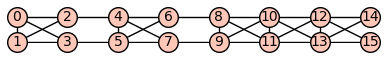

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


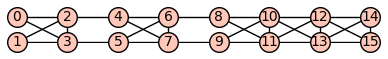

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

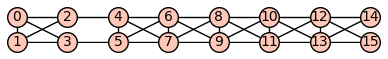

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


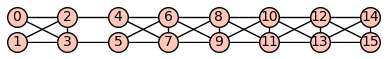

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

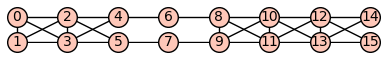

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


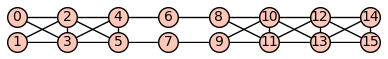

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

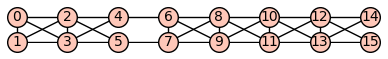

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  2]


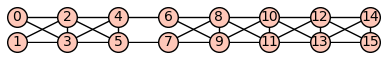

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  3]

 Similarity Matrix=
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0| 1/2 -1/2]
[ 1/2  1/2|   0    0|   0    0|   0    0|   0    0|   0    0|   0    0|-1/2  1/2]
[---------

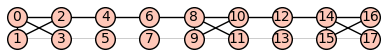

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

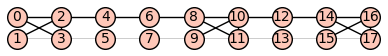

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

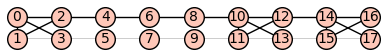

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

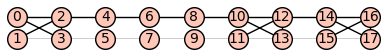

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

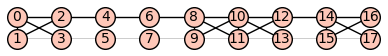

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

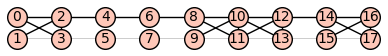

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

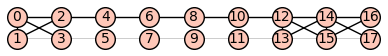

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

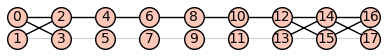

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

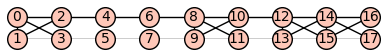

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

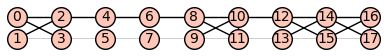

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

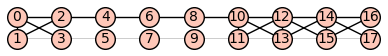

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

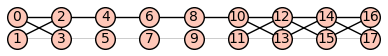

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

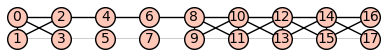

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

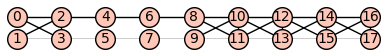

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

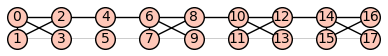

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

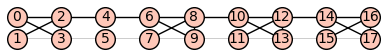

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

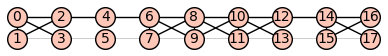

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

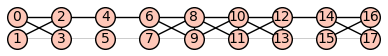

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

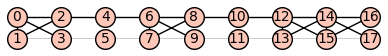

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

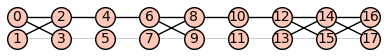

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

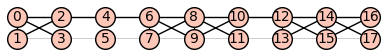

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

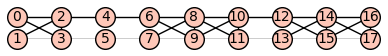

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

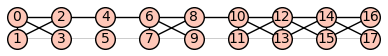

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

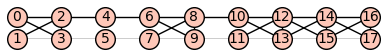

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

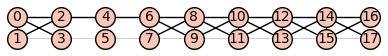

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

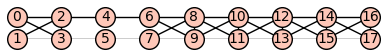

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

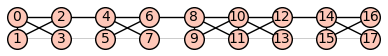

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

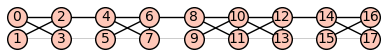

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

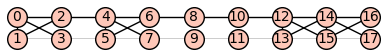

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

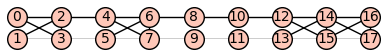

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

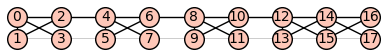

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

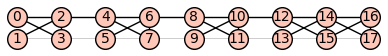

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

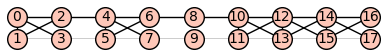

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

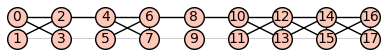

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

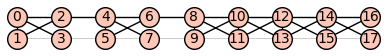

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

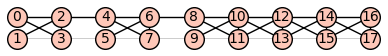

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

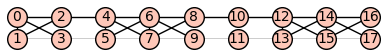

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

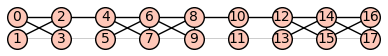

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

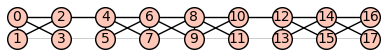

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

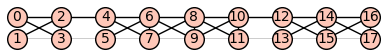

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

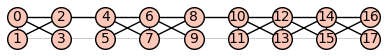

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

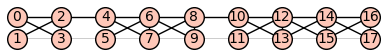

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

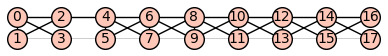

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

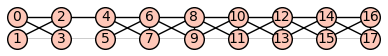

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

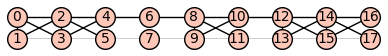

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

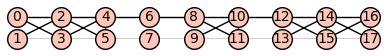

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

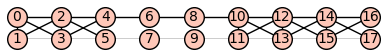

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

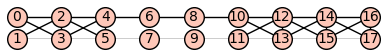

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

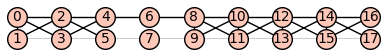

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

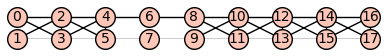

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  2  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

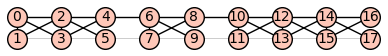

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

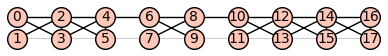

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

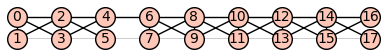

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

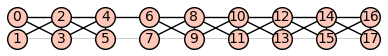

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

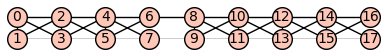

A = 
[ 3 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1  3 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  3  0 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  0  3  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  4 -1 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  2  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

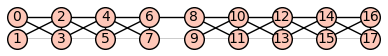

B = 
[ 2  0 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  2 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[-1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1  5 -1 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0 -1 -1 -1  5 -1 -1  0  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1  4 -1 -1  0  0  0  0  0  0  0  0  0]
[ 0  0  0  0 -1 -1 -1  4  0 -1  0  0  0  0  0  0  0  0]
[ 0  0  0  0  0  0 -1  0  3  0 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0 -1  0  3 -1 -1  0  0  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1  0  0]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  5 -1 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0 -1 -1 -1  5 -1 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1 -1  3 -1]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 

In [39]:
for n in range(5,10):
    display_all_pairs_of_xo_graphs_and_similarity_matrix(xo_graphs_and_similarity_matrix_gen(n, laplacian_similarity_matrix_for_xo_graphs_alternating_labels))

Following graphs HAVE same ihara function
{0: [3, 5, 7, 9], 1: [4, 6, 7, 9], 2: [5, 6, 8], 3: [0, 7, 8, 9], 4: [1, 6, 8, 9], 5: [0, 2, 8, 9], 6: [1, 2, 4, 7], 7: [0, 1, 3, 6], 8: [2, 3, 4, 5], 9: [0, 1, 3, 4, 5]}
{0: [3, 5, 7, 9], 1: [4, 6, 7, 9], 2: [5, 6, 8, 9], 3: [0, 7, 8], 4: [1, 6, 8, 9], 5: [0, 2, 8, 9], 6: [1, 2, 4, 7], 7: [0, 1, 3, 6], 8: [2, 3, 4, 5], 9: [0, 1, 2, 4, 5]}
Following graphs HAVE same ihara function
{0: [3, 5, 7, 9], 1: [4, 6, 7, 9], 2: [5, 6, 8], 3: [0, 7, 8, 9], 4: [1, 6, 8, 9], 5: [0, 2, 8, 9], 6: [1, 2, 4, 7], 7: [0, 1, 3, 6], 8: [2, 3, 4, 5], 9: [0, 1, 3, 4, 5]}
{0: [4, 6, 7, 9], 1: [4, 6, 8, 9], 2: [5, 6, 7, 9], 3: [5, 7, 8], 4: [0, 1, 8, 9], 5: [2, 3, 8, 9], 6: [0, 1, 2, 7], 7: [0, 2, 3, 6], 8: [1, 3, 4, 5], 9: [0, 1, 2, 4, 5]}
Following graphs HAVE same ihara function
{0: [3, 5, 7, 9], 1: [4, 6, 7, 9], 2: [5, 6, 8, 9], 3: [0, 7, 8], 4: [1, 6, 8, 9], 5: [0, 2, 8, 9], 6: [1, 2, 4, 7], 7: [0, 1, 3, 6], 8: [2, 3, 4, 5], 9: [0, 1, 2, 4, 5]}
{0: [4, 6, 7, 9], 1

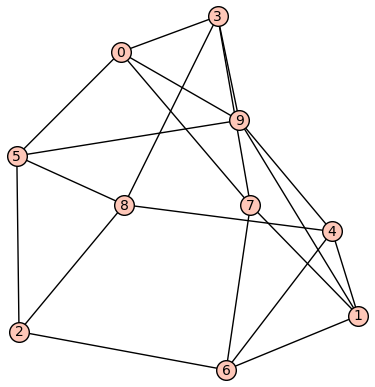

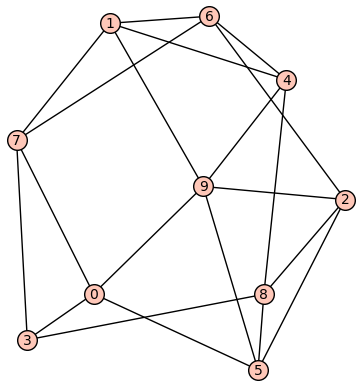

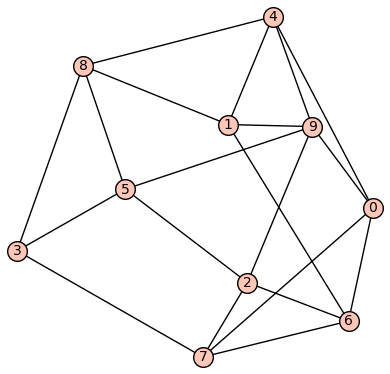

In [42]:
#1 First trio of ihara cospectral graphs 

# Graph strings
graph_strings = (
"{0: [3, 5, 7, 9], 1: [4, 6, 7, 9], 2: [5, 6, 8], 3: [0, 7, 8, 9], 4: [1, 6, 8, 9], 5: [0, 2, 8, 9], 6: [1, 2, 4, 7], 7: [0, 1, 3, 6], 8: [2, 3, 4, 5], 9: [0, 1, 3, 4, 5]}",
"{0: [3, 5, 7, 9], 1: [4, 6, 7, 9], 2: [5, 6, 8, 9], 3: [0, 7, 8], 4: [1, 6, 8, 9], 5: [0, 2, 8, 9], 6: [1, 2, 4, 7], 7: [0, 1, 3, 6], 8: [2, 3, 4, 5], 9: [0, 1, 2, 4, 5]}",
"{0: [4, 6, 7, 9], 1: [4, 6, 8, 9], 2: [5, 6, 7, 9], 3: [5, 7, 8], 4: [0, 1, 8, 9], 5: [2, 3, 8, 9], 6: [0, 1, 2, 7], 7: [0, 2, 3, 6], 8: [1, 3, 4, 5], 9: [0, 1, 2, 4, 5]}"
)

# Parse and convert to Sage graph objects
graphs = parse_sage_graphs(graph_strings)

# Double check if same ihara function
all_pairs_same_ihara_function(graphs)

all_pairs_ihara_cospectral(graphs)

for g in graphs:
    show(g)


Following graphs HAVE same ihara function
{0: [3, 6, 7, 9], 1: [4, 5, 6, 8], 2: [4, 5, 7, 9], 3: [0, 6, 8, 9], 4: [1, 2, 7, 8, 9], 5: [1, 2, 8, 9], 6: [0, 1, 3, 7], 7: [0, 2, 4, 6], 8: [1, 3, 4, 5], 9: [0, 2, 3, 4, 5]}
{0: [3, 4, 6, 7], 1: [4, 5, 8, 9], 2: [5, 6, 8, 9], 3: [0, 6, 7, 9], 4: [0, 1, 7, 8, 9], 5: [1, 2, 7, 9], 6: [0, 2, 3, 8], 7: [0, 3, 4, 5], 8: [1, 2, 4, 6], 9: [1, 2, 3, 4, 5]}
Following graphs HAVE same ihara function
{0: [3, 6, 7, 9], 1: [4, 5, 6, 8], 2: [4, 5, 7, 9], 3: [0, 6, 8, 9], 4: [1, 2, 7, 8, 9], 5: [1, 2, 8, 9], 6: [0, 1, 3, 7], 7: [0, 2, 4, 6], 8: [1, 3, 4, 5], 9: [0, 2, 3, 4, 5]}
{0: [3, 4, 6, 7], 1: [4, 5, 8, 9], 2: [5, 6, 7, 9], 3: [0, 6, 8, 9], 4: [0, 1, 7, 8, 9], 5: [1, 2, 7, 9], 6: [0, 2, 3, 8], 7: [0, 2, 4, 5], 8: [1, 3, 4, 6], 9: [1, 2, 3, 4, 5]}
Following graphs HAVE same ihara function
{0: [3, 4, 6, 7], 1: [4, 5, 8, 9], 2: [5, 6, 8, 9], 3: [0, 6, 7, 9], 4: [0, 1, 7, 8, 9], 5: [1, 2, 7, 9], 6: [0, 2, 3, 8], 7: [0, 3, 4, 5], 8: [1, 2, 4, 6], 9: [1, 2,

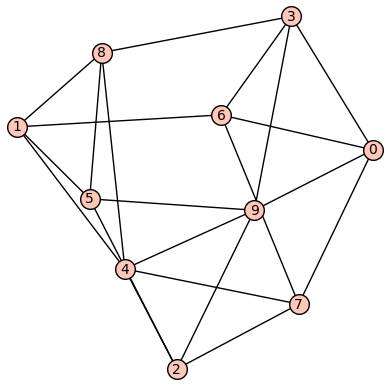

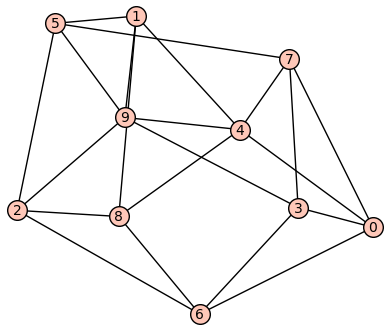

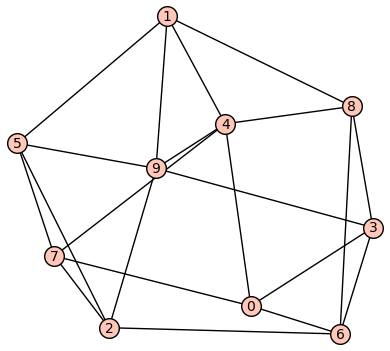

In [38]:
#2 Second trio of ihara cospectral graphs 

# Graph strings
graph_strings = (
"{0: [3, 6, 7, 9], 1: [4, 5, 6, 8], 2: [4, 5, 7, 9], 3: [0, 6, 8, 9], 4: [1, 2, 7, 8, 9], 5: [1, 2, 8, 9], 6: [0, 1, 3, 7], 7: [0, 2, 4, 6], 8: [1, 3, 4, 5], 9: [0, 2, 3, 4, 5]}",
"{0: [3, 4, 6, 7], 1: [4, 5, 8, 9], 2: [5, 6, 8, 9], 3: [0, 6, 7, 9], 4: [0, 1, 7, 8, 9], 5: [1, 2, 7, 9], 6: [0, 2, 3, 8], 7: [0, 3, 4, 5], 8: [1, 2, 4, 6], 9: [1, 2, 3, 4, 5]}",
"{0: [3, 4, 6, 7], 1: [4, 5, 8, 9], 2: [5, 6, 7, 9], 3: [0, 6, 8, 9], 4: [0, 1, 7, 8, 9], 5: [1, 2, 7, 9], 6: [0, 2, 3, 8], 7: [0, 2, 4, 5], 8: [1, 3, 4, 6], 9: [1, 2, 3, 4, 5]}"
)

# Parse and convert to Sage graph objects
graphs = parse_sage_graphs(graph_strings)

# Double check if same ihara function
all_pairs_same_ihara_function(graphs)

all_pairs_ihara_cospectral(graphs)

for g in graphs:
    show(g)

In [112]:
# This cell test all pairs of graphs for the given parameters below
# Parameters:
m = 6
d = 3
k = 4
C = matrix([[0,1,0,0,1,1], [1,1,1,0,0,0], [0,0,1,1,0,1], [1,0,0,1,1,0]])
C_t = C.transpose()
print(C_t)
g1_graphs = graphs.nauty_geng(str(m) + " -c -d" + str(d) +" -D" + str(d))
g1_graphs_list = list(g1_graphs)

g2_graphs = graphs.nauty_geng(str(k) + "-c -d2")
g2_graphs_list = list(g2_graphs)

for g1 in g1_graphs_list:
    for g2 in g2_graphs_list:
        G1, H = GM_switch(g1,g2, C_t)
        if not ihara_cospectral(G1, H):
            show(g1)
            show(g2)
            show(G1)
            show(H)
            print("Not K cospectral")
            



[0 1 0 1]
[1 1 0 0]
[0 1 1 0]
[0 0 1 1]
[1 0 0 1]
[1 0 1 0]


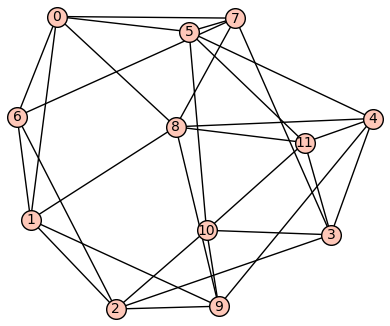

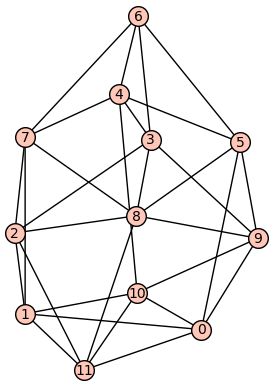

Are isomorphic?: False
Cospectrality
	Adjacency: True
	Laplacian: True
	Signless: True
	Ihara: True
	Nonbacktracking: True


In [24]:
#Generated all-cospectral graphs using two graphs on 6 vertices

C = matrix([[1,1,1,0,0,0], [1,0,1,1,0,0], [1,0,0,1,1,0], [0,1,0,0,1,1], [0,0,1,1,0,1], [0,1,0,0,1,1]])
g1 = Graph({0:[1,5], 4:[5,3], 2:[1,3]})
g2 = Graph({5:[2,4], 3:[2,4], 1:[0,2]})
list = GM_switch(g1,g2,C)
for G1 in list:
    show(G1)

g1 = list[0]
g2 = list[1]

print("Are isomorphic?: " + str(g1.is_isomorphic(g2)))
show_cospectrality(g1,g2)


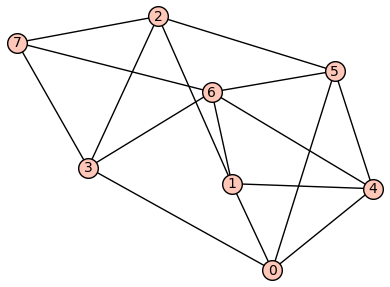

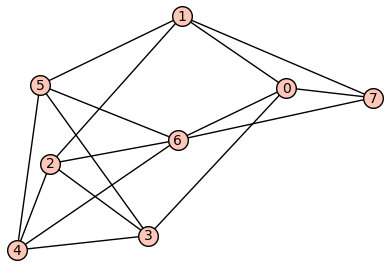

True
these are the adjacency matrix spectrums: 
[4.054156981155888?, 1.529556814050105?, 0.2030291350678458?, 0, 0, -1.173359774543222?, -1.543598836533737?, -3.069784319196880?]
[4.054156981155888?, 1.529556814050105?, 0.2030291350678458?, 0, 0, -1.173359774543222?, -1.543598836533737?, -3.069784319196880?]

these are the laplacian spectrums: 
[5, 0, 4, 4, 4, 2.104893484072469?, 5.602704930702910?, 7.292401585224621?]
[5, 0, 4, 4, 4, 2.104893484072469?, 5.602704930702910?, 7.292401585224621?]

these are the normalized laplacian spectrums: 
[1, 1, 0]
[1, 1, 0]

these are the signless laplacian spectrums: 
[4, 4, 1.037940772323164?, 2.115205055811098?, 2.656902589565021?, 4.68480515122703?, 5.295252765661715?, 8.20989366541198? + 0.?e-95*I]
[4, 4, 1.037940772323164?, 2.115205055811098?, 2.656902589565021?, 4.68480515122703?, 5.295252765661715?, 8.20989366541198? + 0.?e-95*I]

these are the ihara matrix spectrums: 
[3.037235326212268?, 1, 0.7515903008871687? + 1.448696953161461?*I, 0.751

In [52]:
#Generated all-cospectral graphs using two graphs on 4 vertices. Unfortunately, they are isomorphic


C = matrix([[1,1,0,0], [1,0,1,0], [0,1,0,1], [0,0,1,1]])

g1 = Graph({0:[1,3], 2:[1,3]})
g2 = Graph({0:[1,2], 2:[1,3]})

list = GM_switch(g1,g2,C)
for G1 in list:
    show(G1)

g1 = list[0]
g2 = list[1]

print(g1.is_isomorphic(g2))

#are_cospectral(graphs[0],graphs[1])

print("these are the adjacency matrix spectrums: ")
print(g1.spectrum())
print(g2.spectrum())
print()


print("these are the laplacian spectrums: ")
print(g1.kirchhoff_matrix().eigenvalues())
print(g2.kirchhoff_matrix().eigenvalues())
print()


print("these are the normalized laplacian spectrums: ")
print(g1.kirchhoff_matrix(normalized = True).eigenvalues())
print(g2.kirchhoff_matrix(normalized = True).eigenvalues())
print()


print("these are the signless laplacian spectrums: ")
print(g1.kirchhoff_matrix(signless = True).eigenvalues())
print(g2.kirchhoff_matrix(signless = True).eigenvalues())
print()


print("these are the ihara matrix spectrums: ")
print(ihara_matrix(g1).eigenvalues())
print(ihara_matrix(g2).eigenvalues())

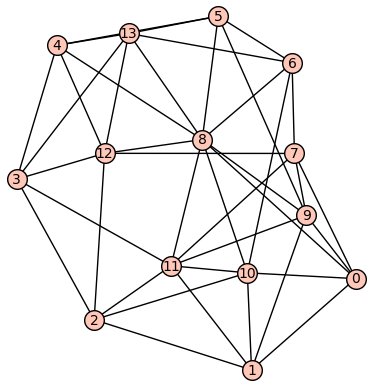

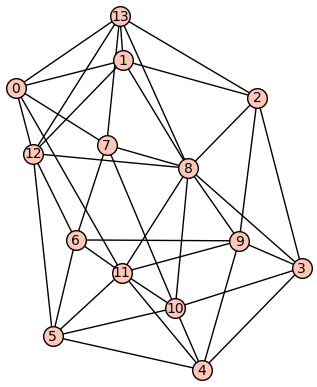

Isomorphic? False
Adjacency Matrix:
Cospectral
Laplacian Matrix: 
Cospectral
Signless laplacian: 
Cospectral
Ihara Matrix: 
Cospectral
Nonbacktracking: 
Cospectral


In [53]:
#Generated all-cospectral graphs using two graphs on 8 and 6 vertices


C = matrix([[1,1,1,0,0,0], [0,1,1,1,0,0], [0,0,1,1,1,0], [0,0,0,1,1,1], [1,0,0,0,1,1], [1,1,0,0,0,1], [1,0,1,0,0,1], [0,1,0,1,1,0]])
g1 = Graph({0:[1,7], 2:[1,3], 4:[3,5], 6:[5,7]})
g2 = Graph({0:[1,2,3,4,5], 3:[1,2], 4:[5]})

list = GM_switch(g1,g2,C)
for G1 in list:
    show(G1)

g1 = list[0]
g2 = list[1]

print("Isomorphic? " + str(g1.is_isomorphic(g2)))

#are_cospectral(graphs[0],graphs[1])

show_cospectrality(g1,g2)

In [ ]:
#Testing cospectrality of graphs on minimum 2 degrees

all_spectrums = []
all_graphs = list(list.nauty_geng("9 -d2"))
for g in all_graphs:
    k_g = ihara_matrix(g)
    all_spectrums.append(k_g.eigenvalues())

graphs_length = len(all_spectrums)
for i in range (0,graphs_length):
    for j in range(0,graphs_length):
        if i != j and all_spectrums[i] == all_spectrums[j]:
            show(all_graphs[i])
            show(all_graphs[j])

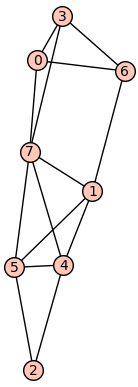

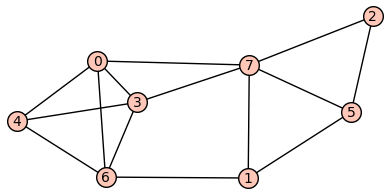

Adjacency Matrix:
Not cospectral
Laplacian Matrix: 
Not cospectral
Signless laplacian: 
Not cospectral
Ihara Matrix: 
Cospectral


In [ ]:
# IMPORTANT: FIND MORE COUNTER EXAMPLES AND TEST HYPOTHESIS

#Counter example is only cospectral in regards to signless laplacian and ihara matrix. 
#We later show that cospectrality in terms of signless laplacian does not imply cospectrality in terms of ihara matrix, but the converse may be true

#Counter example to our 'conjecture' about cospectrality of B or K matrices

g1 = {0:[3,6,7], 6:[3,1], 7:[3,1,5,4], 4:[1,5,2], 5:[1,2]}
g1 = Graph(g1)
show(g1)

g2 = {0:[3,4,6,7], 3:[4,6,7], 6:[4,1], 5:[1,2,7], 7:[1,2]}
g2 = Graph(g2)
show(g2)

show_cospectrality(g1,g2)


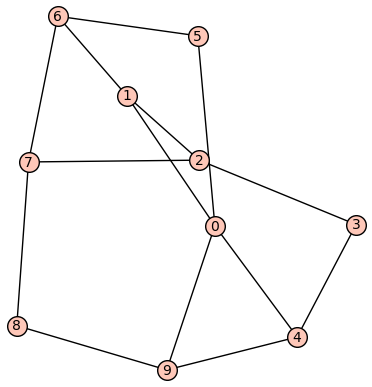

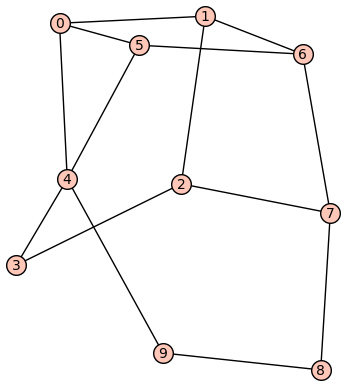

Cospectrality
	Adjacency: False
	Laplacian: False
	Signless: True
	Ihara: False
	Nonbacktracking: False


In [25]:
# FINDINGS: being cospectral in regards to signless laplacian does NOT imply cospectrality in regards to Ihara matrix

#Two graphs on 10 vertices which are cospectral in terms of Q (signless laplacian) matrix

g1 = {0:[1,4,5,9], 6:[1,5,7], 2:[1,3,7], 8:[7,9], 4:[3,9]}
g2 = {0:[1,4,5], 6:[1,5,7], 2:[1,3,7], 8:[7,9], 4:[3,5,9]}

g1 = Graph(g1)
g2 = Graph(g2)

show(g1)
show(g2)

show_cospectrality(g1,g2)

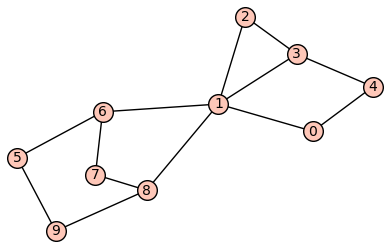

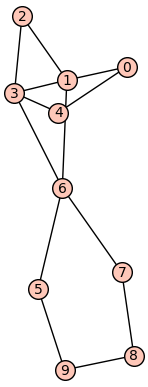

Cospectrality
	Adjacency: False
	Laplacian: False
	Signless: True
	Ihara: False
	Nonbacktracking: False


In [27]:
#Another counter-example like the previous

g1 = {0:[4], 1:[0,2,3,6,8], 3:[2,4], 5:[6,9], 7:[6,8], 9:[8]}
g2 = {0:[4], 1:[0,2,3,6], 3:[2,4,6], 5:[6,9], 7:[6,8], 9:[8]}

g1 = Graph(g1)
g2 = Graph(g2)

show(g1)
show(g2)

show_cospectrality(g1,g2)

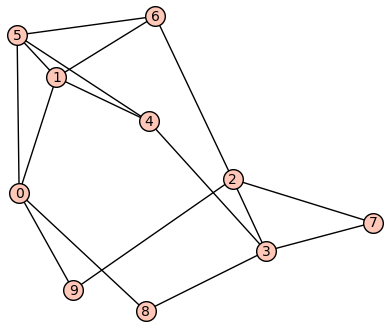

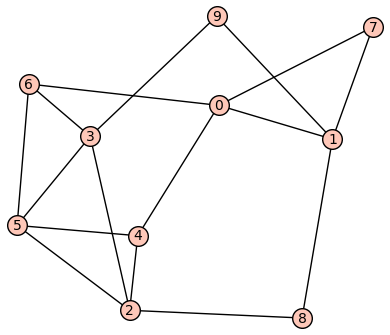

Cospectrality
	Adjacency: True
	Laplacian: True
	Signless: True
	Ihara: True
	Nonbacktracking: True


In [26]:
# ANOTHER NON-REGULAR GRAPH WHICH IS COSPECTRAL IN REGARDS TO IHARA MATRIX WITH MIN DEGREE 2

#Example from paper Dr. Kempton sent us 

g1 = {0:[1,5,8,9], 1:[4,5,6], 2:[3,6,7,9], 3:[4,7,8], 5:[4,6]}
g2 = {0:[1,4,6,7], 1:[7,8,9], 2:[4,5,8,3], 3:[5,6,9], 5:[4,6]}

g1 = Graph(g1)
g2 = Graph(g2)

show(g1)
show(g2)

show_cospectrality(g1,g2)

In [105]:
#Testing diagonalizability of Ihara Matrix of graphs with 8 vertices, connected, and d_min >= 2


all_graphs = list.nauty_geng("9 -c -d2")
print(len(list(all_graphs)))
#for g in all_graphs:
#    find_eigenvalues(g)
# is_it_diagonalizable(all_graphs)

11


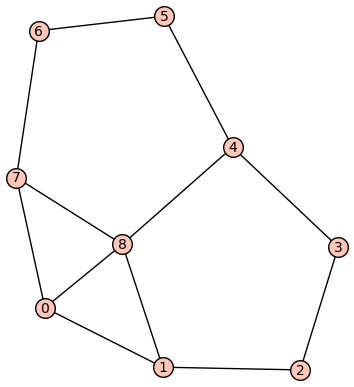

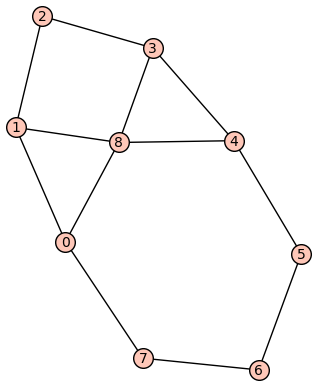

Cospectrality
	Adjacency: True
	Laplacian: False
	Signless: False
	Ihara: False
	Nonbacktracking: False
x^18 + 3*x^16 - 4*x^15 + 4*x^14 - 16*x^13 + 4*x^12 - 36*x^11 + 4*x^10 - 56*x^9 + 8*x^8 - 56*x^7 + 36*x^6 - 40*x^5 + 60*x^4 - 16*x^3 + 56*x^2 + 48
x^18 + 3*x^16 - 4*x^15 + 4*x^14 - 16*x^13 + 2*x^12 - 36*x^11 + 2*x^10 - 52*x^9 + 12*x^8 - 48*x^7 + 33*x^6 - 36*x^5 + 47*x^4 - 16*x^3 + 56*x^2 + 48


In [28]:
#example of two cospectral graphs with minimum degree at least 2

g1 = {0:[1,7,8], 1:[8,2], 3:[2,4], 5:[4,6], 7:[6,8], 8:[4]}
g1 = Graph(g1)
show(g1)
g2 = {0:[1,7,8], 1:[8,2], 3:[2,8,4], 5:[4,6], 7:[6], 8:[4]}
g2 = Graph(g2)
show(g2)
show_cospectrality(g1,g2)
k_g1 = ihara_matrix(g1)
k_g2 = ihara_matrix(g2)

print(k_g1.charpoly())
print(k_g2.charpoly())

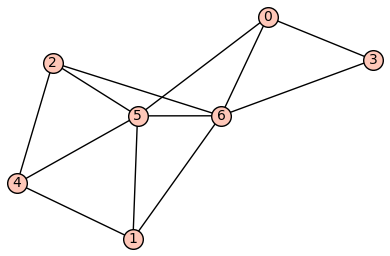

Is diagonalizable: False
[2.585399180895620?, 1, 0.6337669124478448? + 1.141714069356906?*I, 0.6337669124478448? - 1.141714069356906?*I, 0.?e-56 + 1.414213562373095?*I, 0.?e-56 - 1.414213562373095?*I, -0.3757575197436938? + 1.706562943488307?*I, -0.3757575197436938? - 1.706562943488307?*I, -1.050708983151961? + 1.128326170159466?*I, -1.050708983151961? - 1.128326170159466?*I, -0.50000000000000000? + 1.322875655532296?*I, -0.50000000000000000? + 1.322875655532296?*I, -0.50000000000000000? - 1.322875655532296?*I, -0.50000000000000000? - 1.322875655532296?*I]
All eigenvalues found


In [62]:
#reconstructing the counter-example to our conjecture about the diagonalizability of Ihara matrices


g = {0:[3,6,5], 1:[4,5,6], 2:[4,5,6], 3:[0,6], 4:[1,2,5], 5:[0,1,2,4,6], 6:[0,3,5]}
sad_graph = Graph(g)
show(sad_graph)
k_sad = ihara_matrix(sad_graph)
print("Is diagonalizable: " + str(k_sad.is_diagonalizable()))
print(k_sad.eigenvalues())
find_eigenvalues(sad_graph)

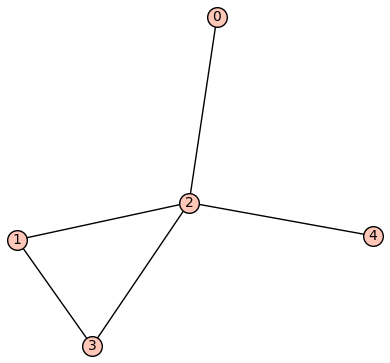

[0 0 1 0 0]
[0 0 1 1 0]
[1 1 0 1 1]
[0 1 1 0 0]
[0 0 1 0 0]

[0 0 0 0 1 1 1 0 0 0]
[0 0 0 1 0 1 1 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 1 0 0 0]
[0 0 0 1 1 1 0 0 0 0]


In [ ]:
#Testing several different graphs to see if they preserve their property of having an equitable partition


#G = Graph({})
#G.add_cycle([0,1,2,3])
#G.add_cycle([4,5,6,7])
#G.add_edges([(0,4),(1,5),(2,6),(3,7)])

G1 = list.CompleteBipartiteGraph(3,3)

G1 = DiGraph(edge_adjacency_nb_matrix(G1))

print(G1.is_equitable([[0,1],[2],[3,4]]))

#G = Graph({7:[0,1,3,5,6], 1:[0,2,3,5], 3:[2,4,5], 5:[4,6]})

#G = Graph({0:[1,2,3,6], 7:[1,4,5,6], 1:[2,4], 6:[3,5], 2:[3,4], 5:[3,4]})

#G = Graph({2:[0,1,3,4], 3:[1]})

show(G1)
#print(G.adjacency_matrix())
#print()
#print(edge_adjacency_nb_matrix(G))

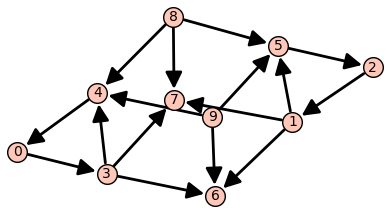

[[0, 2], [1, 3], [4, 5], [6, 7], [8, 9]]


In [ ]:
#checking if nonbacktracking graph has an equitable partition

G1 = Graph({2:[0,1,3,4], 0:[1]})
#print(edge_adjacency_nb_matrix(G))
G1 = DiGraph(edge_adjacency_nb_matrix(G1))
show(G1)
print(G1.coarsest_equitable_refinement([[0,2],[1,3],[4,5],[6,7],[8,9]]))
#G.is_equitable([[0,1],[2],[3,4]])
#G.is_equitable(P, quotient_matrix=True)

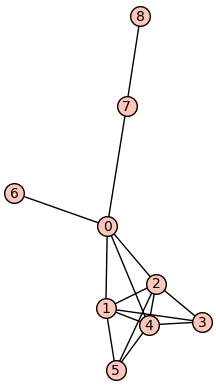

Ihara matrix is diagonalizable: False
[0, -1, -1, -2.432275894706459?, -1.239782941132468?, -0.5653180558400381?, 0.5820380767824201?, 1.431748412515937?, 4.223590402380607?]
lambda: 0
Actual mu: 3.111694220928247?
x and y are orthogonal
Actual mu: 1
x and y are orthogonal
Actual mu: -1.055847110464124? + 1.206703601948119?*I
x and y are orthogonal
Actual mu: -1.055847110464124? - 1.206703601948119?*I
x and y are orthogonal
Actual mu: 0.?e-76 + 1.414213562373095?*I
CORRECT
CORRECT
Actual mu: 0.?e-76 - 1.414213562373095?*I
CORRECT
CORRECT
Actual mu: -0.500000000000000? + 1.936491673103709?*I
x and y are orthogonal
x and y are orthogonal
Actual mu: -0.500000000000000? - 1.936491673103709?*I
x and y are orthogonal
x and y are orthogonal
Actual mu: 0
x and y are orthogonal
x and y are orthogonal

lambda: -1
Actual mu: 3.111694220928247?
x and y are orthogonal
x and y are orthogonal
Actual mu: 1
x and y are orthogonal
x and y are orthogonal
Actual mu: -1.055847110464124? + 1.206703601948119

In [ ]:
#An example of proposition 5.3 calculating the eigenvalues of the Ihara Matrix of some graph on 9 vertices

G1 = deg_two_graph(6,0.5)
G1.add_vertices([6, 7, 8])
G1.add_edges([(6,0),(7,0),(8,7)])
show(G1)
K = ihara_matrix(G1)
print("Ihara matrix is diagonalizable: " + str(K.is_diagonalizable()))
print(G1.adjacency_matrix().eigenvalues())
compute_K_evals(G1)

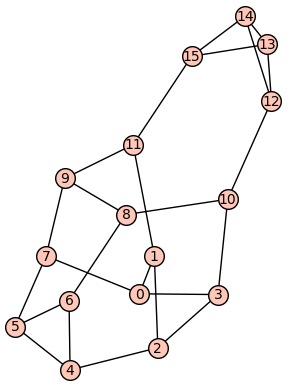

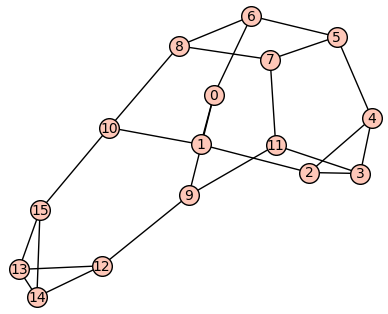

Adjacency Matrix:
Cospectral
Laplacian Matrix: 
Cospectral
Signless laplacian: 
Cospectral
Ihara Matrix: 
Cospectral


In [ ]:
#testing cospectral 3-regular graphs on 16 vertices

g1 = {0:[1,3,7], 2:[3,1,4], 5:[4,6,7], 6:[4,8], 9:[8,7,11], 10:[3,8,12], 11:[1,15], 13:[12,14,15], 14:[12,15],}
g2 = {0:[1,6,9], 2:[1,3,4], 3:[4,11], 5:[4,6,7], 8:[6,7,10], 9:[11,12], 10:[1,15], 11:[7], 13:[12,14,15], 14:[12,15]}
g1 = Graph(g1)
g2 = Graph(g2)
show(g1)
show(g2)
show_cospectrality(g1,g2)

In [ ]:
#using cospectral_graphs() built in function to find cospectral graphs
gen = list.nauty_geng("12 -d3 -D3")
len(list(gen))
#g = graphs.cospectral_graphs(12, graphs=graphs.nauty_geng(12, -d3, -D3))

94

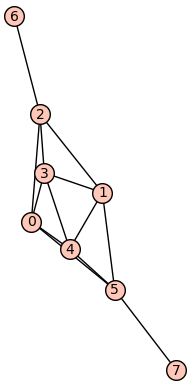

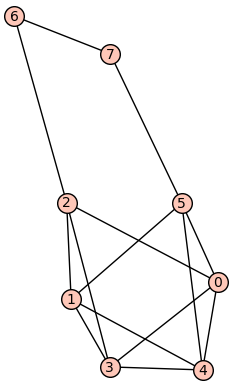

[3.780800801623442?, 1.246979603717467?, 0.4952660978202098?, 0, -0.4450418679126288?, -0.8984559940154224?, -1.801937735804839?, -2.377610905428230?]
[3.805517942736874?, 1.248485253512700?, 1, 0, -0.7220637129691248?, -1, -2, -2.331939483280449?]
Adjacency Matrix:
Not cospectral
Laplacian Matrix: 
Not cospectral
Signless laplacian: 
Not cospectral
Ihara Matrix: 
Not cospectral


In [ ]:
g1 = {0:[2,3,4,5], 1:[2,3,4,5], 2:[3,6], 3:[4], 5:[4,7]}
g1 = Graph(g1)
show(g1)
g2 = {0:[2,3,4,5], 1:[2,3,4,5], 2:[3,6], 3:[4], 5:[4,7], 6:[7]}
g2 = Graph(g2)
show(g2)
print(g1.spectrum())
print(g2.spectrum())
show_cospectrality(g1,g2)

In [ ]:
#These are two really big bi-regular graphs that are supposed to be cospectral. I screwed it up though

g1 = {0:[1,5,15], 1:[2,10], 2:[3,7], 3:[4,12], 4:[5,9], 6:[5,11,7], 8:[7,13,9], 10:[9,11], 12:[11,13], 14:[13,16,22], 16:[17,33], 17:[15,18], 18:[19,48], 19:[20,49], 20:[21,50], 21:[22,53], 23:[15,22,23], 24:[25,48], 25:[26,49], 26:[27,50], 27:[28,53], 28:[29,34], 29:[30,35], 30:[31,36], 31:[32,37], 32:[33,38], 33:[47], 34:[39,41], 35:[42,40], 36:[39,43], 37:[40,44], 38:[39,45], 47:[40,46], 41:[42,46], 43:[42,44], 45:[44,46], 51:[48,50,52], 52:[49,53]}
g1 = Graph(g1)
g2 = {0:[1,5,33], 1:[2,10], 2:[3,7], 3:[4,12], 4:[5,9], 6:[5,11,7], 8:[7,13,9], 10:[9,11], 12:[11,13], 13:[34], 15:[16,32,47], 16:[17,48], 17:[18,49], 18:[19,50], 19:[20,51], 20:[21,52], 21:[22,47], 22:[23,48], 23:[24,49], 24:[25,50], 25:[26,51], 26:[27,52], 27:[28,33], 28:[29,34], 29:[30,35], 30:[31,36], 31:[32,37], 32:[38], 41:[33,42,46], 42:[34,43], 43:[35,44], 44:[36,45], 45:[37,46], 46:[38], 39:[35,37,40], 40:[36,38], 53:[47,49,51], 54:[48,50,52]}
g2 = Graph(g2)
print(g1.adjacency_matrix().eigenvalues() == g2.adjacency_matrix().eigenvalues())

False
